In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import glob
import time
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


In [32]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'
TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

SEED = 666

In [33]:
#seeding
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [34]:
class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except Exception as e:
            print('\nWarning:', e.__class__.__name__, f'for {path} Replacing with zeros image')
            img = np.zeros((*tuple(resize[:2]), 3), dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)

In [35]:
class MetadataLoader:
    def __init__(self, train_metadata_path = TRAIN_METADATA_PATH, test_metadata_path = TEST_METADATA_PATH, lazy_load = True):
      self.train_metadata_path = train_metadata_path
      self.test_metadata_path = test_metadata_path
      self._lazy_load = lazy_load
      self._train_df = None
      self._test_df = None
      
      if not self._lazy_load:
        self._load_trainset()
        self._load_testset()
        
    def _read(self, is_read_train_metadata = True):
        csv_file = self.train_metadata_path
        if not is_read_train_metadata:
            csv_file = self.test_metadata_path
            
        df = pd.read_csv(csv_file)
        
        df["Image"] = df["ID"].str.slice(stop=12)
        df["Diagnosis"] = df["ID"].str.slice(start=13)
        
        if is_read_train_metadata:
            duplicates_to_remove = [
                56346, 56347, 56348, 56349,
                56350, 56351, 1171830, 1171831,
                1171832, 1171833, 1171834, 1171835,
                3705312, 3705313, 3705314, 3705315,
                3705316, 3705317, 3842478, 3842479,
                3842480, 3842481, 3842482, 3842483
            ]
            df = df.drop(index=duplicates_to_remove)
            df = df.reset_index(drop=True)
        
        df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
        df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
        
        return df
    
    def sync_with_actual_file(self):
        """
        Some files maybe didn't contain legitimate images, so we need to remove them from dataframe if any
        """
        if self._train_df is None:
            self._load_trainset()
        
        dcms = glob.glob(os.path.join(TRAIN_DATA_PATH, '*.dcm'))
        dcms = [os.path.basename(dcm)[:-4] for dcm in dcms]
        
        self._train_df = self._train_df[self._train_df.index.isin(dcms)]
        


    def _load_trainset(self):
        self._train_df = self._read(is_read_train_metadata=True)
    
    def _load_testset(self):
        self._test_df = self._read(is_read_train_metadata=False)
    
    def reload_set(self):
        self._load_trainset()
        self._load_testset()
    
    @property
    def train_df(self):
        if self._train_df is not None:
            return self._train_df
        self._load_trainset()
        return self._train_df
    
    @property
    def test_df(self):
        if self._test_df is not None:
            return self._test_df
        self._load_testset()
        return self._test_df

In [36]:
def plot_data_distribution(df, legend_suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(legend_suptitle)
    sns.countplot(data=df['Label'], x='any', hue='any',  ax=axes[0], palette='Reds')
    axes[0].set_title("Distribution of ICH Diagnoses (Positive vs Negative)")
    axes[0].set_xlabel("ICH Diagnosis (0=Negative, 1=Positive)")
    axes[0].set_ylabel('Count')
    for c in axes[0].containers:
        axes[0].bar_label(c , fmt=lambda x: f'{(x/df["Label"]["any"].count())*100:0.1f}%')

    df_label_counts = df['Label'].sum(axis=0)[1:].reset_index()
    df_label_counts.columns = ['Label', 'Count']
        
    sns.barplot(x='Label', y='Count', data=df_label_counts, hue='Label' , palette='Set2')
    axes[1].set_title('Percentage of Positive Occurrences by ICH Type')
    axes[1].set_xlabel('ICH Type')
    axes[1].set_ylabel('Positive Occurrence (%)')
    plt.setp(axes[1].get_xticklabels(), rotation=45)
    for c in axes[1].containers:
        axes[1].bar_label(c ,fmt=lambda x: f'{x/len(df.index)*100:0.01f}%')

In [37]:
df_loader = MetadataLoader()
df = df_loader.train_df
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_ffff82e46     0        0                0                0            0   
ID_ffff922b9     1        0                0                1            0   
ID_ffffb670a     1        0                0                0            1   
ID_ffffcbff8     0        0                0                0            0   
ID_fffff9393     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
...               ...  
ID_ffff82e46        0  
ID_ffff922b9        0  
ID_ffffb670a        0  
ID_ffffcbff8        0  
ID_fffff9393        0  

[752803 rows x 6 columns]

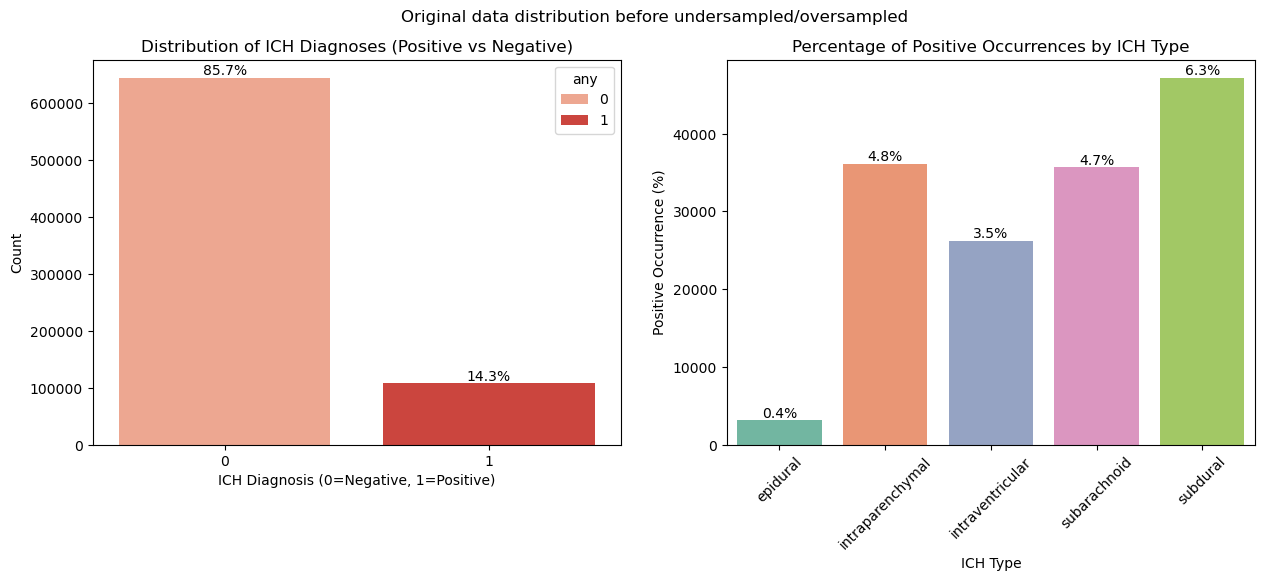

In [38]:
plot_data_distribution(df, 'Original data distribution before undersampled/oversampled')

In [39]:
# oversampling some highly imbalance ich type
epidural_df = df[df['Label']['epidural'] == 1]
oversampled_df = pd.concat([df, epidural_df, epidural_df, epidural_df])
df = oversampled_df

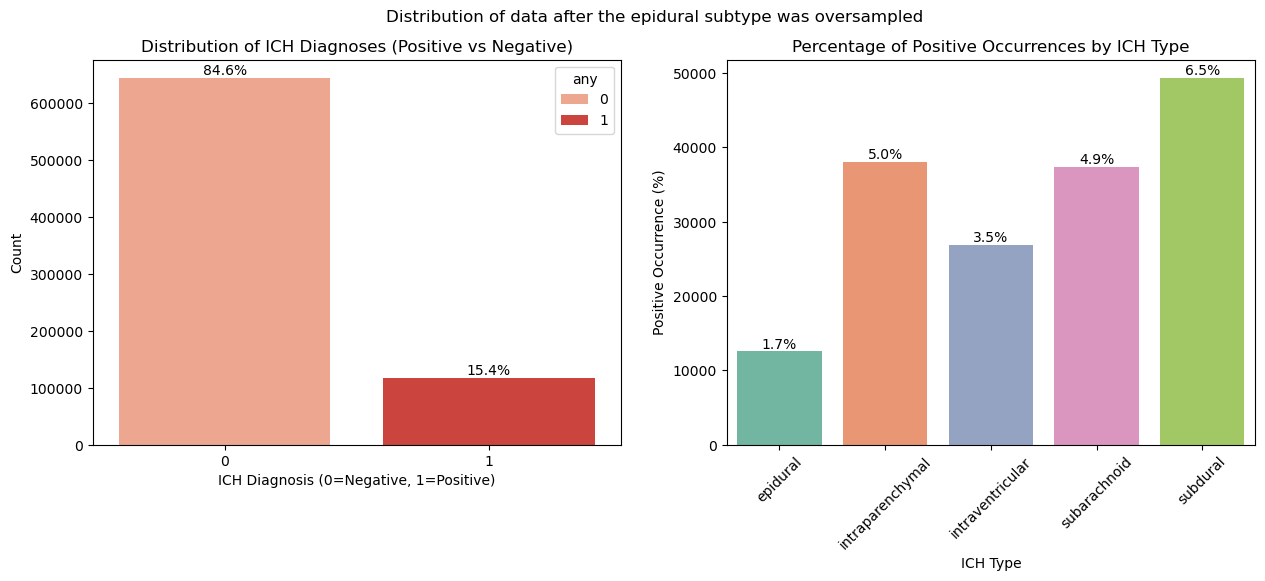

In [40]:
plot_data_distribution(df, 'Distribution of data after the epidural subtype was oversampled')

In [41]:
df['Label']['any'].value_counts()

any
0    644870
1    117368
Name: count, dtype: int64

In [42]:
num_positive_diag = df['Label'][df['Label']['any'] == 1].shape[0]
df_negative_diag_selection = df[df['Label']['any'] == 0].sample(n=int(num_positive_diag*1.25), random_state=42, replace=False)
df_negative_diag_selection

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_1c6bfb61e     0        0                0                0            0   
ID_c59dfca21     0        0                0                0            0   
ID_f339f98d4     0        0                0                0            0   
ID_bfd1b9b9f     0        0                0                0            0   
ID_0c0326411     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_f5e233ae3     0        0                0                0            0   
ID_df9696f51     0        0                0                0            0   
ID_bad097f96     0        0                0                0            0   
ID_ec8584266     0        0                0                0            0   
ID_a3421189a     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_1c6bfb61e        0  
ID_c59dfca21        0  
ID_f339f98d4        0  
ID_bfd1b9b9f        0  
ID_0c0326411        0  
...               ...  
ID_f5e233ae3        0  
ID_df9696f51        0  
ID_bad097f96        0  
ID_ec8584266        0  
ID_a3421189a        0  

[146710 rows x 6 columns]

In [43]:
df = df[(df['Label']['any'] == 1) | df.index.isin(df_negative_diag_selection.index.values)]
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_0001de0e8     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_ffd27f702     1        1                0                0            0   
ID_ffd4cf367     1        1                0                0            1   
ID_ffd67050a     1        1                0                0            0   
ID_ffe17f20d     1        1                0                0            0   
ID_fff9bb57a     1        1                1                1            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_00005679d        0  
ID_0000ca2f6        0  
ID_0000f1657        0  
ID_0001de0e8        0  
...               ...  
ID_ffd27f702        0  
ID_ffd4cf367        0  
ID_ffd67050a        0  
ID_ffe17f20d        0  
ID_fff9bb57a        0  

[264078 rows x 6 columns]

In [44]:
df = df.sample(frac=1)
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_99196d0ab     1        0                0                0            0   
ID_2b0190b58     0        0                0                0            0   
ID_056e14224     1        1                0                0            0   
ID_525e72262     0        0                0                0            0   
ID_b00eddf10     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_21e825c20     0        0                0                0            0   
ID_85141c704     1        0                1                0            0   
ID_b4add57dd     0        0                0                0            0   
ID_02f0d7dbb     0        0                0                0            0   
ID_7d29263ce     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_99196d0ab        1  
ID_2b0190b58        0  
ID_056e14224        0  
ID_525e72262        0  
ID_b00eddf10        0  
...               ...  
ID_21e825c20        0  
ID_85141c704        1  
ID_b4add57dd        0  
ID_02f0d7dbb        0  
ID_7d29263ce        1  

[264078 rows x 6 columns]

In [45]:
df['Label']['any'].value_counts()

any
0    146710
1    117368
Name: count, dtype: int64

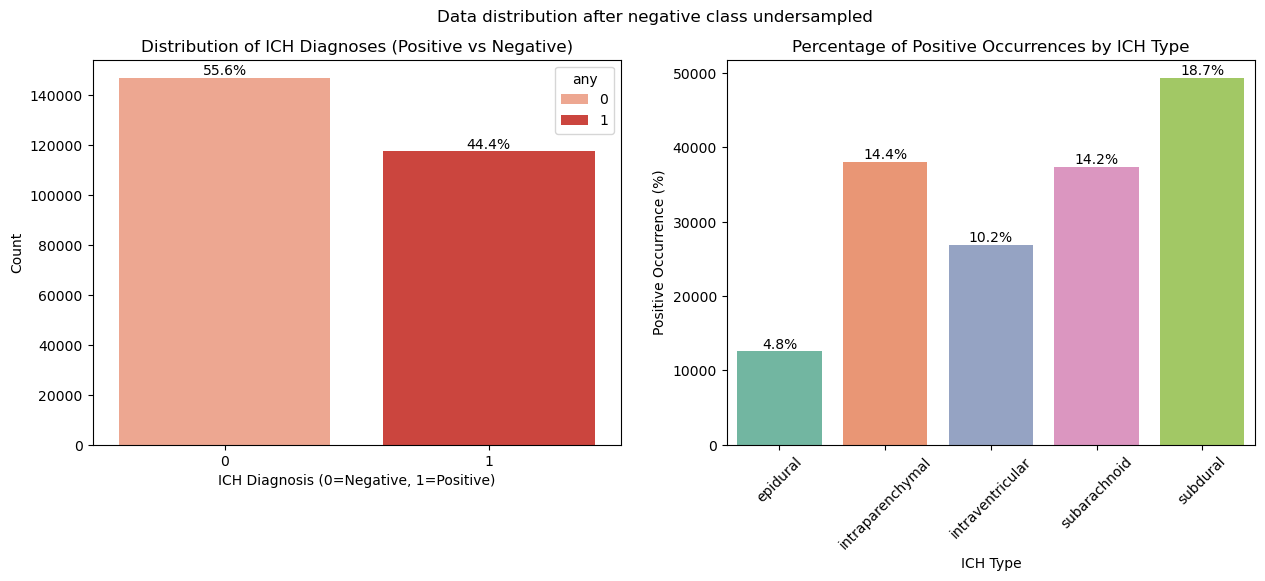

In [46]:
plot_data_distribution(df, 'Data distribution after negative class undersampled')

In [49]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, under_sampling=False, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)

        return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.dcm'
            img = ImagePreparationUtil.read(img_path, self.img_shape[:2])
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [59]:
class DeepModel():
    def __init__(self, base,input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, base_name='base_model', weights='imagenet', freeze_base=False, saving_path=None, verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.base_name = base_name
        self.weights = weights
        self.freeze_base = freeze_base
        self.saving_path = saving_path
        self.verbose = verbose
        self._build()
        self._create_saving_path_if_none()
    
    def _build(self):
        K.clear_session()
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape)
        base.trainable = not self.freeze_base
            
        x = base.output
        # x = layers.Dense(512, activation='relu', name='hidden_layer_1')(x)
        # x = layers.Dropout(0.4)(x)
        # x = layers.Dense(512, activation='relu', name='hidden_layer_2')(x)
        # x = layers.Dropout(0.6)(x)
        # x = layers.Dense(512, activation='relu', name='hidden_layer_3')(x)
        x = layers.Dropout(0.2)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        
        
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics=[
                'acc', 
                keras.metrics.Precision(),
                keras.metrics.Recall(),
                keras.metrics.AUC(name='auc_roc', curve='ROC'),
                keras.metrics.AUC(name='auc_pr', curve='PR'),
                keras.metrics.F1Score(name='f1_score'),
            ]
        )
        
    def _create_saving_path_if_none(self):
        if self.saving_path is None:
            print('saving_path is None. Automatically create path for save training utilities')
            saving_path = os.path.join('saved_model', self.base.__name__)
            os.makedirs(saving_path, exist_ok=True)
            self.saving_path = saving_path
            print(self.saving_path, 'created for saving_path')
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        curr_time = int(time.time())
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/{epoch:02d}-%s.weights.h5' % (self.saving_path, curr_time), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=True),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)), verbose=1),
            keras.callbacks.EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss', patience=5, mode='min'),
            keras.callbacks.CSVLogger(filename='%s/%s.csv'%(self.saving_path, f'{curr_time}-train_log'))
        ]
        # class_weight = generate_class_weights(train_df.to_numpy(), multi_class=False, one_hot_encoded=True)
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs,
            # class_weight=class_weight, 
            verbose=self.verbose
        )
    
    def save(self, filename, overwrite=True):
        _, ext = os.path.splitext(filename)
        if ext != '.keras':
          filename = f'{filename}.keras'
          
        p = os.path.join(self.saving_path, filename)
        self.model.save(p, overwrite=overwrite)
        print('model saved to:', p)
        
    def load_weights(self, path, *args, **kwargs):
        self.model.load_weights(path, *args, **kwargs)
        
    def load(self, path, *args, **kwargs):
        self.model = keras.models.load_model(path, *args, **kwargs)
        

In [51]:
EPOCH = 10
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32
N_CLASSES = 6

In [60]:
# keras.applications.EfficientNetV2B3
model = DeepModel(
    base=keras.applications.EfficientNetB4,
    weights='imagenet',
    freeze_base=False,
    input_shape=INPUT_SHAPE, 
    batch_size=BATCH_SIZE, 
    num_epochs=EPOCH,
    num_classes=N_CLASSES,
    learning_rate=0.000125, 
    decay_rate=0.5, 
    decay_steps=1,
    base_name='efficientnetb4'
)

saving_path is None. Automatically create path for save training utilities
saved_model/EfficientNetB4 created for saving_path


In [61]:
msss = MultilabelStratifiedShuffleSplit(n_splits=EPOCH, test_size=0.15, random_state=SEED)
X = df.index
Y = df['Label'].values

msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
valid_idx = msss_splits[1]
 

In [62]:
np.random.shuffle(train_idx)

hist = model.fit(df.iloc[train_idx], df.iloc[valid_idx])


Epoch 1: LearningRateScheduler setting learning rate to 0.000125.
Epoch 1/10
6138/7015 ━━━━━━━━━━━━━━━━━━━━ 5:18 363ms/step - acc: 0.5027 - auc_pr: 0.9886 - auc_roc: 0.9969 - f1_score: 0.3307 - loss: 0.0498 - precision: 0.9586 - recall: 0.9383
Epoch 5: val_loss did not improve from 0.12135
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 2951s 417ms/step - acc: 0.5015 - auc_pr: 0.9886 - auc_roc: 0.9969 - f1_score: 0.3301 - loss: 0.0498 - precision: 0.9585 - recall: 0.9384 - val_acc: 0.4437 - val_auc_pr: 0.9461 - val_auc_roc: 0.9813 - val_f1_score: 0.3427 - val_loss: 0.1238 - val_precision: 0.9009 - val_recall: 0.8673 - learning_rate: 7.8125e-06

Epoch 6: LearningRateScheduler setting learning rate to 3.90625e-06.
Epoch 6/10
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - acc: 0.4501 - auc_pr: 0.9929 - auc_roc: 0.9981 - f1_score: 0.3207 - loss: 0.0381 - precision: 0.9681 - recall: 0.9535
Epoch 9: val_loss did not improve from 0.12135
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 2968s 419ms/step - acc: 0.4501 - auc_pr:

I0000 00:00:1733784472.730517  112355 service.cc:148] XLA service 0x7f05b8003e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733784472.730565  112355 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1733784480.986359  112355 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733784541.754336  112355 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7015/7015 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - acc: 0.8540 - auc_pr: 0.8171 - auc_roc: 0.9344 - f1_score: 0.1643 - loss: 0.2233 - precision: 0.8032 - recall: 0.6529
Epoch 1: val_loss improved from inf to 0.33432, saving model to saved_model/EfficientNetB4/01-1733784380.weights.h5
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 3054s 413ms/step - acc: 0.8540 - auc_pr: 0.8171 - auc_roc: 0.9344 - f1_score: 0.1643 - loss: 0.2233 - precision: 0.8032 - recall: 0.6529 - val_acc: 0.6751 - val_auc_pr: 0.7566 - val_auc_roc: 0.9002 - val_f1_score: 0.2034 - val_loss: 0.3343 - val_precision: 0.9263 - val_recall: 0.3649 - learning_rate: 1.2500e-04

Epoch 2: LearningRateScheduler setting learning rate to 6.25e-05.
Epoch 2/10
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - acc: 0.7381 - auc_pr: 0.9408 - auc_roc: 0.9822 - f1_score: 0.2689 - loss: 0.1211 - precision: 0.9003 - recall: 0.8325
Epoch 2: val_loss improved from 0.33432 to 0.22332, saving model to saved_model/EfficientNetB4/02-1733784380.weights.h5
7015/7015 ━━

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7015/7015 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - acc: 0.6274 - auc_pr: 0.9690 - auc_roc: 0.9913 - f1_score: 0.3230 - loss: 0.0846 - precision: 0.9283 - recall: 0.8883
Epoch 3: val_loss improved from 0.22332 to 0.17927, saving model to saved_model/EfficientNetB4/03-1733784380.weights.h5
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 2977s 421ms/step - acc: 0.6274 - auc_pr: 0.9690 - auc_roc: 0.9913 - f1_score: 0.3230 - loss: 0.0846 - precision: 0.9283 - recall: 0.8883 - val_acc: 0.5541 - val_auc_pr: 0.9022 - val_auc_roc: 0.9636 - val_f1_score: 0.2871 - val_loss: 0.1793 - val_precision: 0.8994 - val_recall: 0.7302 - learning_rate: 3.1250e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.5625e-05.
Epoch 4/10
7015/7015 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - acc: 0.5429 - auc_pr: 0.9826 - auc_roc: 0.9952 - f1_score: 0.3282 - loss: 0.0619 - precision: 0.9483 - recall: 0.9213
Epoch 4: val_loss improved from 0.17927 to 0.12135, saving model to saved_model/EfficientNetB4/04-1733784380.weights.h5
7015/7

: 

: 

: 

3805/7015 ━━━━━━━━━━━━━━━━━━━━ 19:24 363ms/step - acc: 0.5074 - auc_pr: 0.9885 - auc_roc: 0.9969 - f1_score: 0.3328 - loss: 0.0502 - precision: 0.9586 - recall: 0.9380

In [ ]:
model.save('final_efficientnetb4.keras')

model saved to: saved_model/EfficientNetB4/final_efficientnetb4.keras


In [89]:
train_history = pd.DataFrame(hist.history)
train_history.insert(0, 'epoch', range(1,len(train_history)+1))
train_history['f1_score'] = train_history['f1_score'].apply(lambda x: [t.numpy() for t in x])
train_history['val_f1_score'] = train_history['val_f1_score'].apply(lambda x: [t.numpy() for t in x])
train_history.to_csv(os.path.join(model.saving_path, 'train_history.csv'), index=False)

In [90]:
train_history

,epoch,acc,auc_pr,auc_roc,f1_score,loss,precision,recall,val_acc,val_auc_pr,val_auc_roc,val_f1_score,val_loss,val_precision,val_recall,learning_rate
0,1,0.834471,0.875024,0.958449,"[0.62660587, 0.081160866, 0.09174259, 0.147634...",0.183117,0.847642,0.722413,0.675081,0.756555,0.900182,"[0.6703701, 0.0052826195, 0.30451718, 0.084804...",0.334317,0.926345,0.364913,1.250000e-04
1,2,0.733228,0.944197,0.983355,"[0.6114601, 0.48278746, 0.1431061, 0.17939882,...",0.116972,0.902349,0.839025,0.744043,0.852722,0.945362,"[0.6585298, 0.21343143, 0.06347883, 0.0705802,...",0.223322,0.883855,0.626868,6.250000e-05
2,3,0.625851,0.969877,0.991536,"[0.6241572, 0.57639134, 0.17420836, 0.19918287...",0.083295,0.929100,0.890711,0.554094,0.902171,0.963626,"[0.7008999, 0.4162228, 0.19523603, 0.1302501, ...",0.179275,0.899410,0.730174,3.125000e-05
3,4,0.537803,0.982668,0.995159,"[0.6434132, 0.4933148, 0.20799734, 0.21793123,...",0.061605,0.947975,0.921948,0.465923,0.947350,0.981736,"[0.6964838, 0.626118, 0.1373952, 0.12825929, 0...",0.121350,0.908707,0.854236,1.562500e-05
4,5,0.493282,0.988563,0.996887,"[0.6679689, 0.48162028, 0.20696639, 0.18924917...",0.049339,0.958005,0.938662,0.443684,0.946065,0.981262,"[0.6839316, 0.5911892, 0.20450157, 0.18598378,...",0.123822,0.900873,0.867350,7.812500e-06
5,6,0.474786,0.990860,0.997504,"[0.67287314, 0.4529777, 0.21168497, 0.20625584...",0.043579,0.963296,0.946245,0.395295,0.945786,0.980577,"[0.7286236, 0.5691096, 0.18975039, 0.15695886,...",0.125588,0.901820,0.873716,3.906250e-06
6,7,0.460945,0.992060,0.997857,"[0.681373, 0.42325413, 0.2104985, 0.19781701, ...",0.040390,0.965996,0.950448,0.403095,0.945251,0.980931,"[0.73094845, 0.5415289, 0.21683164, 0.15997931...",0.126100,0.897311,0.878518,1.953125e-06
7,8,0.453787,0.992571,0.997945,"[0.6880234, 0.4096017, 0.21536024, 0.19086638,...",0.038878,0.967193,0.952560,0.392947,0.944761,0.980286,"[0.73138046, 0.5427203, 0.19880787, 0.16246565...",0.127505,0.898618,0.878273,9.765625e-07
8,9,0.449648,0.992840,0.998037,"[0.6899642, 0.4120342, 0.21644577, 0.1952275, ...",0.038216,0.968076,0.953631,0.392872,0.944885,0.980397,"[0.7332712, 0.5289473, 0.20587124, 0.16764626,...",0.127332,0.898583,0.878831,4.882813e-07


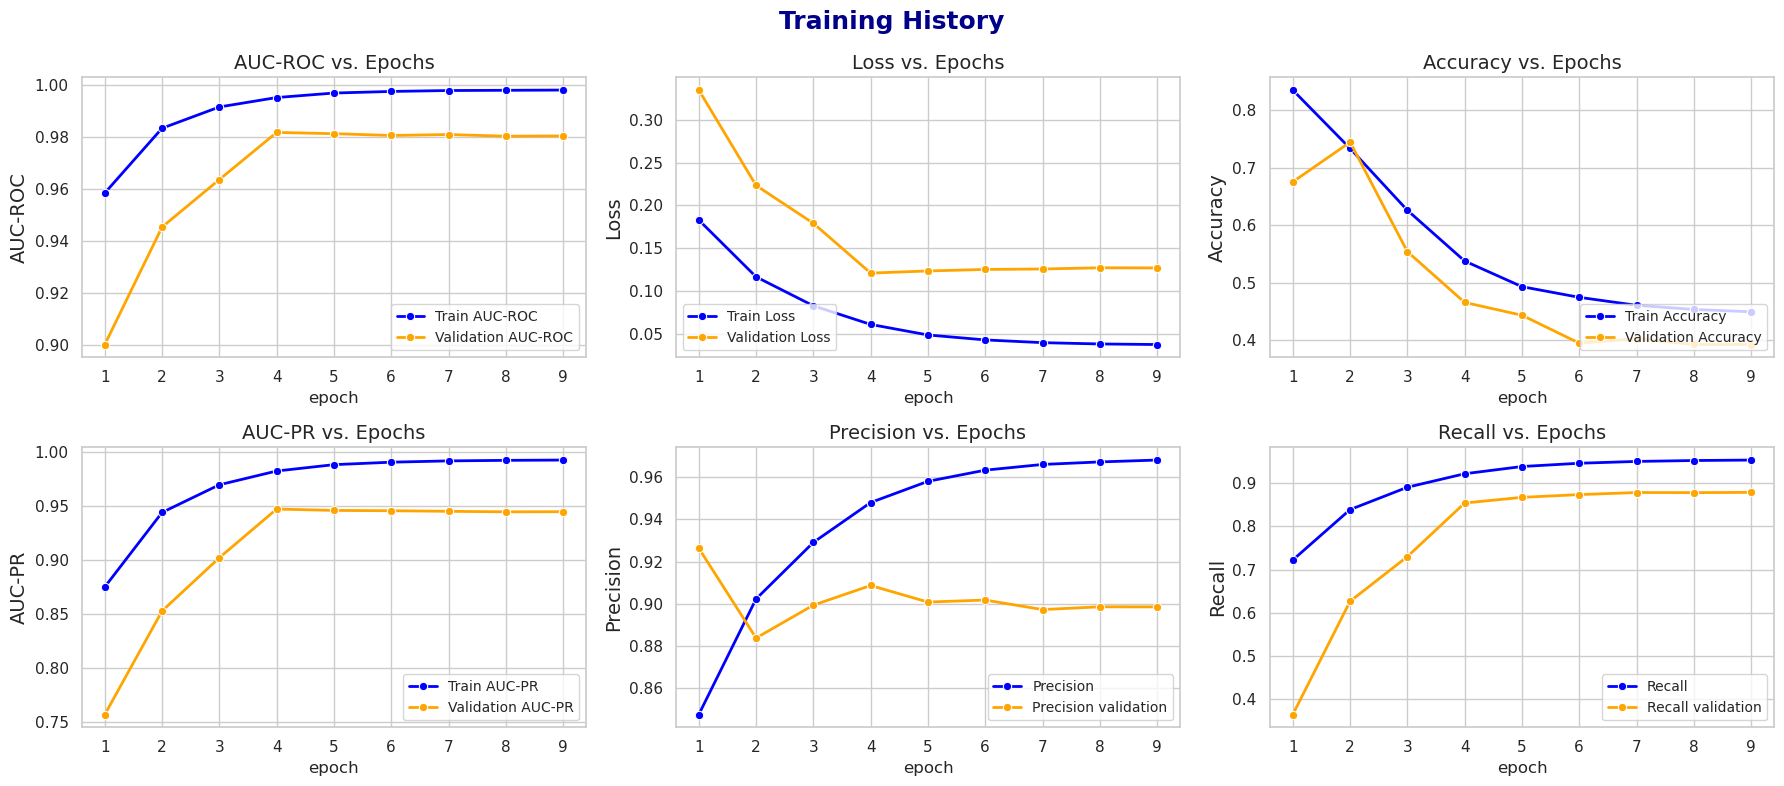

In [92]:

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=False)
fig.suptitle("Training History", fontsize=18, fontweight="bold", color="darkblue")

# 1st subplot: AUC-ROC
sns.lineplot(data=train_history, x='epoch', y='auc_roc', label='Train AUC-ROC', ax=axes[0, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_auc_roc', label='Validation AUC-ROC', ax=axes[0, 0], color='orange', linewidth=2, marker='o')
# lambda arguments : expression
# axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
axes[0, 0].set_ylabel("AUC-ROC", fontsize=14)
axes[0, 0].set_title("AUC-ROC vs. Epochs", fontsize=14)
axes[0, 0].legend(loc="lower right", fontsize=10)

# 2nd subplot: Loss
sns.lineplot(data=train_history, x='epoch', y='loss', label='Train Loss', ax=axes[0, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_loss', label='Validation Loss', ax=axes[0, 1], color='orange', linewidth=2, marker='o')
# axes[1].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 1].set_ylabel("Loss", fontsize=14)
axes[0, 1].set_title("Loss vs. Epochs", fontsize=14)
axes[0, 1].legend(loc="lower left", fontsize=10)

# 3rd subplot: Accuracy
sns.lineplot(data=train_history, x='epoch', y='acc', label='Train Accuracy', ax=axes[0, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_acc', label='Validation Accuracy', ax=axes[0, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 2].set_ylabel("Accuracy", fontsize=14)
axes[0, 2].set_title("Accuracy vs. Epochs", fontsize=14)
axes[0, 2].legend(loc="lower right", fontsize=10)

# 4th subplot: AUC-PR
sns.lineplot(data=train_history, x='epoch', y='auc_pr', label='Train AUC-PR', ax=axes[1, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_auc_pr', label='Validation AUC-PR', ax=axes[1, 0], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 0].set_ylabel("AUC-PR", fontsize=14)
axes[1, 0].set_title("AUC-PR vs. Epochs", fontsize=14)
axes[1, 0].legend(loc="lower right", fontsize=10)

# 5th subplot: F1-score
sns.lineplot(data=train_history, x='epoch', y='precision', label='Precision', ax=axes[1, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_precision', label='Precision validation', ax=axes[1, 1], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 1].set_ylabel("Precision", fontsize=14)
axes[1, 1].set_title("Precision vs. Epochs", fontsize=14)
axes[1, 1].legend(loc="lower right", fontsize=10)

# 6th subplot: F1-score
sns.lineplot(data=train_history, x='epoch', y='recall', label='Recall', ax=axes[1, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_recall', label='Recall validation', ax=axes[1, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 2].set_ylabel("Recall", fontsize=14)
axes[1, 2].set_title("Recall vs. Epochs", fontsize=14)
axes[1, 2].legend(loc="lower right", fontsize=10)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle
plt.show()

In [106]:
test_df = df.iloc[valid_idx]
test_df = test_df.sample(frac=1)
test_data_gen = TrainDataGenerator(
    img_ids=test_df.index, 
    labels=test_df,
    img_dir=TRAIN_DATA_PATH,
    img_shape=INPUT_SHAPE,
    num_classes=N_CLASSES,
    batch_size=15,
    under_sampling=False,
    workers=128,
    use_multiprocessing=True
)

In [225]:
x_test, y_test = test_data_gen[5]
y_test_pred = model.model(x_test,training=False)
y_test = y_test.squeeze()
y_test_pred = y_test_pred.numpy().squeeze()

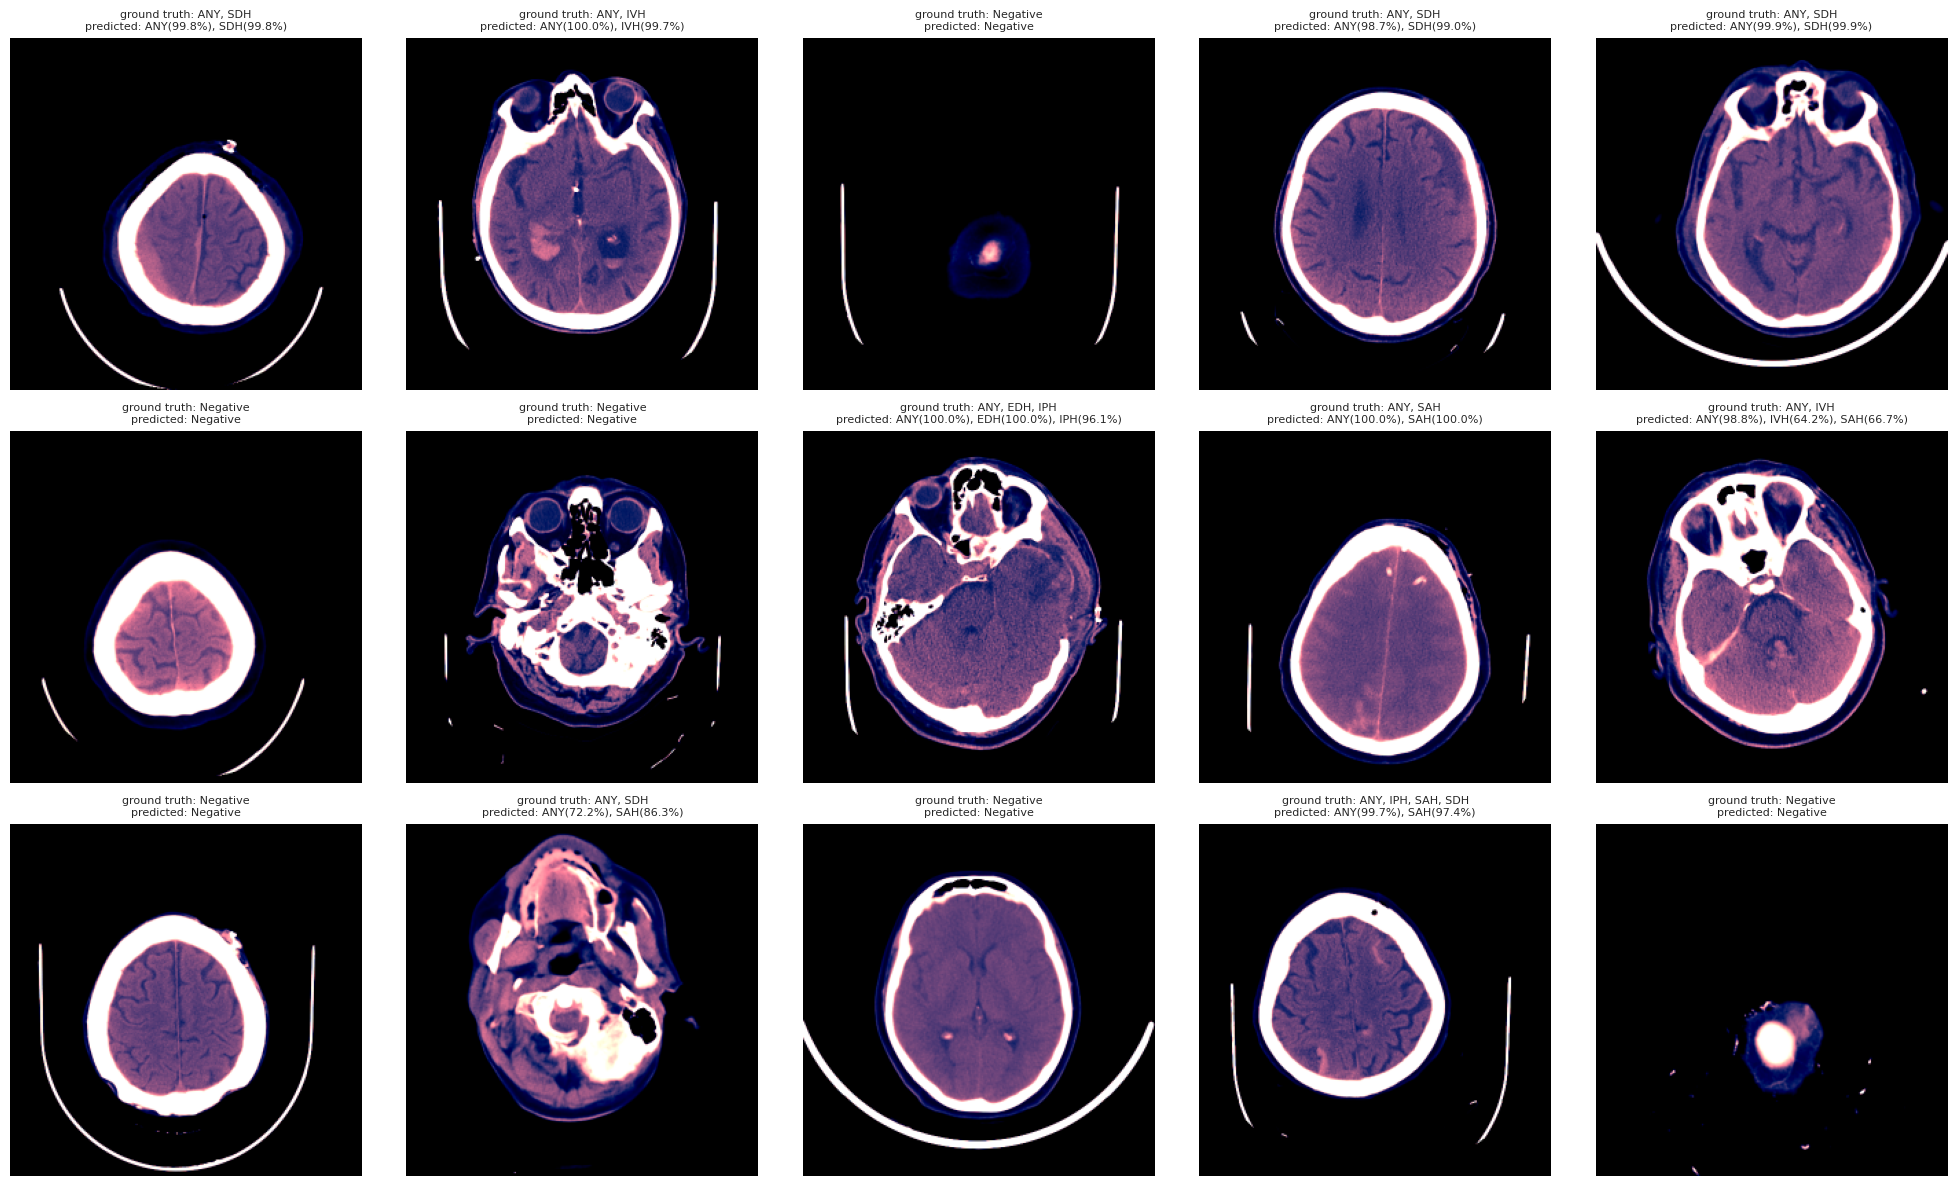

In [226]:
labels_map = {
    0: 'ANY', # any
    1: 'EDH', # epidural
    2: 'IPH', # intraparenchymal
    3: 'IVH', # intraventricular
    4: 'SAH', # subarachnoid
    5: 'SDH', # subdural
}

# sanity check
N, M = int(np.ceil(len(y_test_pred)/5)), 5
fig, axes = plt.subplots(N, M, figsize=(M*4,N*4))
for i, ax in enumerate(axes.flat):
    if i < len(y_test_pred):
        ground_truth = ", ".join([labels_map[j] for j in np.where(y_test[i] == 1)[0]])
        ground_truth = 'ground truth: ' + (ground_truth if len(ground_truth) > 0 else 'Negative')
        
        
        predicted = ", ".join(['%s(%s)' % (labels_map[j], f'{y_test_pred[i][j]*100:0.01f}%') for j in np.where(y_test_pred[i] >= 0.5)[0]])
        predicted = '\npredicted: ' + (predicted if len(predicted) > 0 else 'Negative')
        # confidient = '\nconfidient: ' + (f'{y_test_pred[i]*100:0.001f}%' if y_test_pred[i] >= 0.5 else f'{(1-y_test_pred[i])*100:0.001f}%')
        ax.imshow(x_test[i], cmap=plt.cm.bone)
        ax.axis('off')
        ax.set_title(ground_truth + predicted)
        ax.title.set_size(8)
    else:
        ax.axis('off')

fig.tight_layout()
fig.show()

In [235]:
class GradCAM():
	def __init__(self, model_path, classIdx, layerName=None):
		self.model = keras.models.load_model(model_path)
		self.classIdx = classIdx
		self.layerName = layerName

		
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):

		for layer in reversed(self.model.layers):
			if len(layer.output_shape) == 4:
				return layer.name

	
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):

		gradModel = keras.models.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
                     
				self.model.output])

		with tf.GradientTape() as tape:
		
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		grads = tape.gradient(loss, convOutputs)

		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads


		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

	
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)


		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

	
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):

		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)
	
		return (heatmap, output)

In [252]:
label_idx = np.argmax(y_test_pred[6])
test_gc_img = x_test[6]

gc_model_path = '/workspace/saved_model/EfficientNetB4/final_efficientnetb4.keras'
grad_cam = GradCAM(gc_model_path, label_idx, 'top_conv')

In [253]:
heatmap = grad_cam.compute_heatmap(test_gc_img[np.newaxis,...])

img_copy = np.copy(test_gc_img)
img_copy -= img_copy.min((0,1))
img_copy = (255*img_copy).astype(np.uint8)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (test_gc_img.shape[1], test_gc_img.shape[0]))
(heatmap, output) = grad_cam.overlay_heatmap(heatmap, img_copy, alpha=0.5)

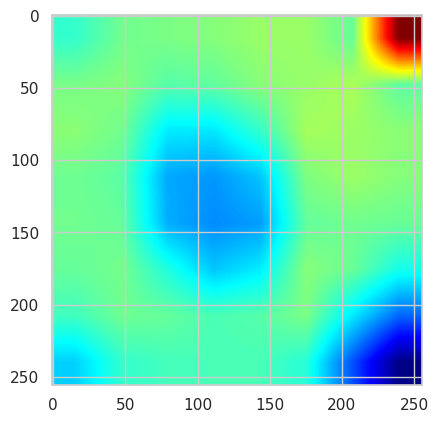

In [254]:
plt.imshow(heatmap)
plt.show()

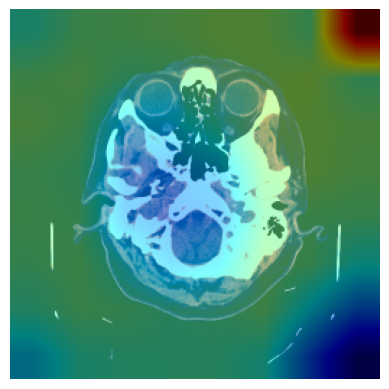

In [255]:
plt.imshow(output)
plt.axis('off')
plt.show()